# Recreates AutoEncoder model in Chapter 3 of "Generative Deep Learning" by Foster

# Get MNIST data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./Data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./Data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/train-images-idx3-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/train-labels-idx1-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Data/MNIST/raw



# Visualize an image

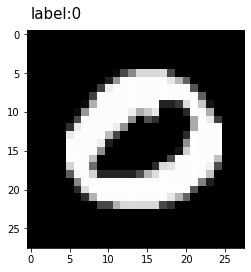

torch.Size([28, 28])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def my_imshow(img, label, prediction=None):
    npimg = img.numpy()
    plt.imshow(img, cmap='gray')
    plt.text(0, -2, f'label:{label}', fontsize=15)
    if prediction: 
      plt.text(20, -2, f'pred:{prediction}', fontsize=15)
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)
idx = 0
my_imshow(torch.squeeze(images[idx], 0), classes[labels[idx]])
torch.squeeze(images[idx], 0).shape

# Model architecture for Encoder

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class Encoder(nn.Module):
    def __init__(self, in_channels, conv_channels, conv_filters, 
                 conv_strides, dense_units):
        super().__init__()


        self.conv0 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=conv_channels[0], 
                               kernel_size=conv_filters[0], stride=conv_strides[0], 
                               padding='same')
        
        for i in range(1, len(conv_channels)):
            exec(f"""self.conv{i} = nn.Conv2d(in_channels=conv_channels[i-1], 
                        out_channels=conv_channels[i], 
                        kernel_size=conv_filters[i], stride=conv_strides[i], 
                        padding=1 if conv_strides[i] > 1 else 'same')"""
            )
        
        self.flatten1 = nn.Flatten()
        self.dense1 = nn.Linear(in_features=3136, out_features=dense_units[0], bias=True)     


    def forward(self, x):
        x = F.leaky_relu(self.conv0(x))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.flatten1(x) 
        x = self.dense1(x)

        return x

conv_channels = [32, 64, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [1, 2, 2, 1]
dense_units = [2]
my_encoder = Encoder(in_channels=1, conv_channels=conv_channels, 
             conv_filters=conv_filters, conv_strides=conv_strides, 
             dense_units=dense_units)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
my_encoder = my_encoder.to(device)

summary(my_encoder, input_size=(1, 28, 28))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Conv2d-4             [-1, 64, 7, 7]          36,928
           Flatten-5                 [-1, 3136]               0
            Linear-6                    [-1, 2]           6,274
Total params: 98,946
Trainable params: 98,946
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.38
Estimated Total Size (MB): 0.74
----------------------------------------------------------------


# Model Architecture for Decoder

In [ ]:
class Decoder(nn.Module):

  def __init__(self, in_dim, tconv_channels, tconv_filters, tconv_strides, 
               dense_units, output_padding, batch_size=2):
    super().__init__()
    self.batch_size=batch_size
    self.dense1 = nn.Linear(in_dim, dense_units[0])
    
    self.tconv0 = nn.ConvTranspose2d(in_channels=64, 
                                     out_channels=tconv_channels[0], 
                                     kernel_size=tconv_filters[0], 
                                     stride=tconv_strides[0], 
                                     padding=1, output_padding=output_padding[0])

    for i in range(1, len(tconv_channels)):
      exec(f"""self.tconv{i} = nn.ConvTranspose2d(in_channels=tconv_channels[i-1], 
                        out_channels=tconv_channels[i], 
                        kernel_size=tconv_filters[i], stride=tconv_strides[i], 
                        padding=1,
                        output_padding=output_padding[i])"""
          )
    
  def forward(self, x):
    x = self.dense1(x)

    #x = x.view(-1, 64, 7, 7)
    x = torch.reshape(x, [-1, 64, 7, 7])

    x = F.leaky_relu(self.tconv0(x))
    x = F.leaky_relu(self.tconv1(x))
    x = F.leaky_relu(self.tconv2(x))
    x = F.sigmoid(self.tconv3(x))
    return x


tconv_channels = [64, 64, 32, 1]
tconv_filters = [3, 3, 3, 3]
tconv_strides = [1, 2, 2, 1]
dense_units = [3136]
output_padding=[0,1,1,0]
my_decoder = Decoder(in_dim=2, tconv_channels=tconv_channels, 
             tconv_filters=tconv_filters, tconv_strides=tconv_strides, 
             dense_units=dense_units, output_padding=output_padding)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
my_decoder = my_decoder.to(device)
summary(my_decoder, input_size=(2,))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]           9,408
   ConvTranspose2d-2             [-1, 64, 7, 7]          36,928
   ConvTranspose2d-3           [-1, 64, 14, 14]          36,928
   ConvTranspose2d-4           [-1, 32, 28, 28]          18,464
   ConvTranspose2d-5            [-1, 1, 28, 28]             289
Total params: 102,017
Trainable params: 102,017
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.39
Estimated Total Size (MB): 0.73
----------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Model Architecture for AutoEncoder

In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self, in_channels, dec_in_dim, conv_channels, conv_filters, conv_strides, 
                       enc_dense_units, tconv_channels, tconv_filters, tconv_strides,
                       dec_dense_units, output_padding):
      super().__init__()
      self.encoder = Encoder(in_channels=in_channels, conv_channels=conv_channels, 
             conv_filters=conv_filters, conv_strides=conv_strides, 
             dense_units=enc_dense_units)
      self.decoder = Decoder(in_dim=dec_in_dim, tconv_channels=tconv_channels, 
             tconv_filters=tconv_filters, tconv_strides=tconv_strides, 
             dense_units=dense_units, output_padding=output_padding, batch_size=32)

    def forward(self, x, decode=True):
      return self.decoder(self.encoder(x)) if decode else self.encoder(x)



tconv_channels = [64, 64, 32, 1]
tconv_filters = [3, 3, 3, 3]
tconv_strides = [1, 2, 2, 1]
dec_dense_units = [3136]
output_padding=[0,1,1,0]
conv_channels = [32, 64, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [1, 2, 2, 1]
enc_dense_units = [2]

my_auto_encoder = AutoEncoder(1, 2, conv_channels, conv_filters, conv_strides, 
                              enc_dense_units, tconv_channels, tconv_filters, 
                              tconv_strides,dec_dense_units, output_padding)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
my_auto_encoder = my_auto_encoder.to(device)
summary(my_auto_encoder, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Conv2d-4             [-1, 64, 7, 7]          36,928
           Flatten-5                 [-1, 3136]               0
            Linear-6                    [-1, 2]           6,274
           Encoder-7                    [-1, 2]               0
            Linear-8                 [-1, 3136]           9,408
   ConvTranspose2d-9             [-1, 64, 7, 7]          36,928
  ConvTranspose2d-10           [-1, 64, 14, 14]          36,928
  ConvTranspose2d-11           [-1, 32, 28, 28]          18,464
  ConvTranspose2d-12            [-1, 1, 28, 28]             289
          Decoder-13            [-1, 1, 28, 28]               0
Total params: 200,963
Trainable pa

# Training

In [ ]:
def calculate_test_loss(autoencoder, test_loader, criterion, device):
    autoencoder.eval()
    with torch.no_grad(): 
 
        reconstructed_images = []
        original_images = []

        for images, labels in test_loader:
            images = images.to(device)
            outputs = autoencoder(images)
            reconstructed_images.append(outputs.cpu())
            original_images.append(images.cpu())
  
        reconstructed_images = torch.cat(reconstructed_images)
        original_images = torch.cat(original_images) 
        test_loss = criterion(reconstructed_images, original_images)
    return test_loss.item()

In [ ]:
from tqdm.notebook import tqdm
import torch.optim as optim

torch.manual_seed(555)
epochs = 20
criterion = nn.MSELoss()
optimizer = optim.Adam(my_auto_encoder.parameters(), lr=0.001)

train_loss_epoch = []
test_loss_epoch = []
for epoch in tqdm(range(1, epochs+1)):
  my_auto_encoder.train()
  loss_train_total = 0
  train_loss_batch = []

  progress_bar = tqdm(trainloader, desc=f'epoch: {epoch}', leave=False, disable=False)
  for batch in progress_bar:

    my_auto_encoder.zero_grad()

    batch = tuple(b.to(device) for b in batch)
    images, labels = batch[0], batch[1]
    
    my_auto_encoder.to(device)
    outputs = my_auto_encoder(images)
    loss = criterion(outputs, images)

    loss_train_total += loss.item()
    train_loss_batch.append(loss.item())

    loss.backward()
    optimizer.step()

    progress_bar.set_postfix(
        {
            'training_loss (per image)': '{:.3f}'.format(loss.item()/len(batch))
        }
    )

  
  tqdm.write(f'\nEpoch: {epoch}')

  loss_train_avg = loss_train_total / len(trainloader)
  train_loss_epoch.append(loss_train_avg)
  tqdm.write(f'Avg Training Loss: {loss_train_avg}')

  test_loss = calculate_test_loss(my_auto_encoder, testloader, criterion, device)
  test_loss_epoch.append(test_loss)
  tqdm.write(f'Avg Test Loss: {test_loss}')



  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 1
Avg Training Loss: 0.04859805170496305
Avg Test Loss: 0.043172866106033325


epoch: 2:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 2
Avg Training Loss: 0.04214909482598305
Avg Test Loss: 0.04131460189819336


epoch: 3:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 3
Avg Training Loss: 0.04087083843549093
Avg Test Loss: 0.04041479155421257


epoch: 4:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 4
Avg Training Loss: 0.040084743960698443
Avg Test Loss: 0.03997171297669411


epoch: 5:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 5
Avg Training Loss: 0.03952112659613292
Avg Test Loss: 0.03952454403042793


epoch: 6:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 6
Avg Training Loss: 0.03909048904081186
Avg Test Loss: 0.03917406499385834


epoch: 7:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 7
Avg Training Loss: 0.03868274757564068
Avg Test Loss: 0.03876710310578346


epoch: 8:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 8
Avg Training Loss: 0.03833520354827245
Avg Test Loss: 0.03881533071398735


epoch: 9:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 9
Avg Training Loss: 0.03807740743060907
Avg Test Loss: 0.0384511761367321


epoch: 10:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 10
Avg Training Loss: 0.037796541699767115
Avg Test Loss: 0.03859814256429672


epoch: 11:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 11
Avg Training Loss: 0.03758930574456851
Avg Test Loss: 0.03776905685663223


epoch: 12:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 12
Avg Training Loss: 0.037370497460166616
Avg Test Loss: 0.03816907852888107


epoch: 13:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 13
Avg Training Loss: 0.037160463690757754
Avg Test Loss: 0.03787042573094368


epoch: 14:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 14
Avg Training Loss: 0.03704914452334245
Avg Test Loss: 0.03779184818267822


epoch: 15:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 15
Avg Training Loss: 0.03692006999055544
Avg Test Loss: 0.03767209127545357


epoch: 16:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 16
Avg Training Loss: 0.036822803461551666
Avg Test Loss: 0.037582967430353165


epoch: 17:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 17
Avg Training Loss: 0.0366409548163414
Avg Test Loss: 0.03786163777112961


epoch: 18:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 18
Avg Training Loss: 0.03656161134640376
Avg Test Loss: 0.03738483041524887


epoch: 19:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 19
Avg Training Loss: 0.03640852439304193
Avg Test Loss: 0.037414200603961945


epoch: 20:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 20
Avg Training Loss: 0.03639107578098774
Avg Test Loss: 0.0373055674135685


# Loss Curves on Train/Test




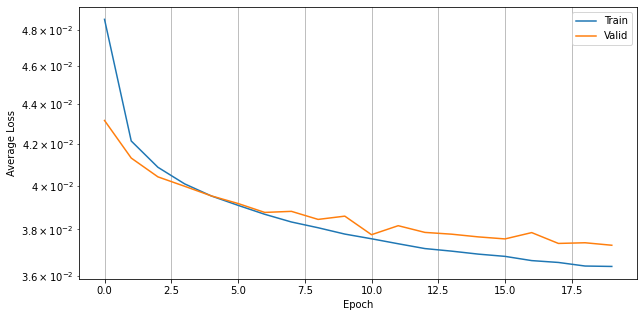

In [ ]:
plt.figure(figsize=(10,5))
plt.semilogy(train_loss_epoch, label='Train')
plt.semilogy(test_loss_epoch, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid()
plt.legend()
plt.show()

# Save/Load the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

torch.save(my_auto_encoder.state_dict(), '/content/drive/My Drive/Models/MNIST_AE_epoch20.model')


Mounted at /content/drive/


In [ ]:
from google.colab import drive

tconv_channels = [64, 64, 32, 1]
tconv_filters = [3, 3, 3, 3]
tconv_strides = [1, 2, 2, 1]
dec_dense_units = [3136]
output_padding=[0,1,1,0]
conv_channels = [32, 64, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [1, 2, 2, 1]
enc_dense_units = [2]

drive.mount('/content/drive/')
my_auto_encoder = AutoEncoder(1, 2, conv_channels, conv_filters, conv_strides, 
                              enc_dense_units, tconv_channels, tconv_filters, 
                              tconv_strides,dec_dense_units, output_padding)

my_auto_encoder.load_state_dict(torch.load('/content/drive/My Drive/Models/MNIST_AE_epoch20.model'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_auto_encoder = my_auto_encoder.to(device)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Visualize Encoded Space

In [ ]:
def autoencode_images(autoencoder, dataloader, criterion, device):
    autoencoder.eval()
    with torch.no_grad(): 
 
        encoded_images = []
        original_labels = []
        original_images = []
        reconstructed_images = []

        for images, labels in dataloader: 
            images = images.to(device)
            outputs_encoded = autoencoder(images, decode=False)
            outputs_decoded = autoencoder(images, decode=True)
            reconstructed_images.append(outputs_decoded.cpu())
            encoded_images.append(outputs_encoded.cpu())
            original_labels.append(labels.cpu())
            original_images.append(images.cpu())
  

    return original_images, original_labels, encoded_images, reconstructed_images

criterion = nn.MSELoss()
original_images, original_labels, encoded_images, reconstructed_images = (
    autoencode_images(my_auto_encoder, testloader, criterion, device)
)
original_images = torch.cat(original_images, 0)
original_labels = torch.cat(original_labels, 0)
encoded_images = torch.cat(encoded_images, 0)
reconstructed_images = torch.cat(reconstructed_images, 0)

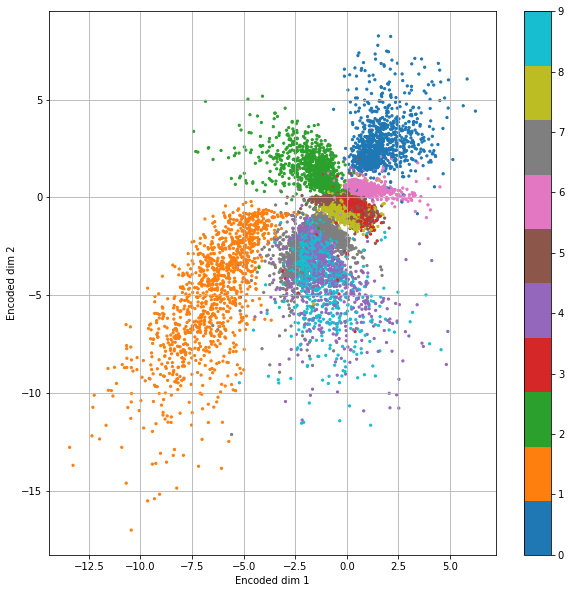

In [ ]:
plt.figure(figsize=(10,10))

plt.scatter(encoded_images[:,0].numpy(), encoded_images[:,1], c=original_labels, cmap='tab10', s=5)
plt.colorbar(ticks=np.linspace(0, 10, 11))
plt.xlabel('Encoded dim 1')
plt.ylabel('Encoded dim 2')
plt.grid()

plt.show()



# Visualize Reconstructed images from Test set


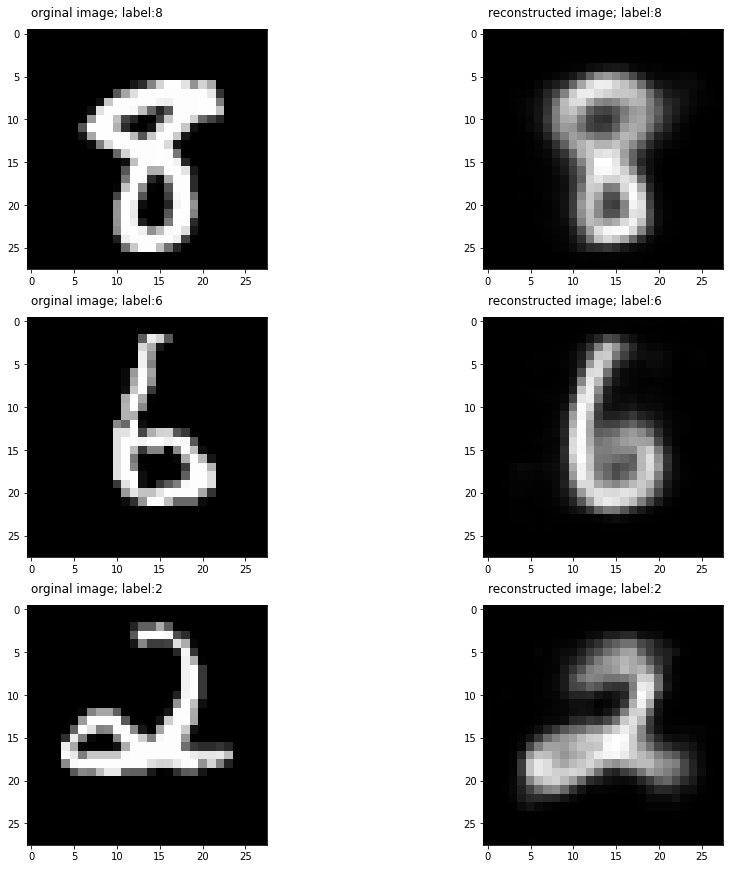

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(15,15))

for i in range(3):
    idx = np.random.choice(range(original_images.shape[0]), size=1)[0]
    img = torch.squeeze(original_images[idx], 0)
    axs[i,0].imshow(img.numpy(), cmap='gray')
    axs[i,0].text(0, -2, f'orginal image; label:{classes[original_labels[idx]]}', fontsize=12)

    img = torch.squeeze(reconstructed_images[idx], 0)
    axs[i,1].imshow(img.numpy(), cmap='gray')
    axs[i,1].text(0, -2, f'reconstructed image; label:{classes[original_labels[idx]]}', fontsize=12)




# Generate novel images

In [ ]:
x = torch.zeros(32,2)
x[0] = torch.FloatTensor([-2.5, 2.5]) # near 2 cluster
x[1] = torch.FloatTensor([-5, -2.5])  # near 1 cluster 
x[2] = torch.FloatTensor([1.25, 2.5])  # near 0 cluster 
x[3] = torch.FloatTensor([1.25, 0])  # near 0 cluster 
x[4] = torch.FloatTensor([-120, 500])  # not near anything
x = x.to(device)
outputs = my_auto_encoder.decoder(x)

outputs.shape

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([32, 1, 28, 28])

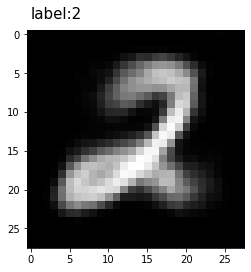

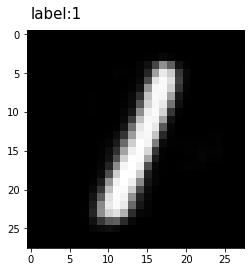

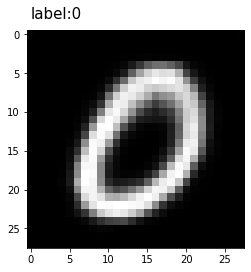

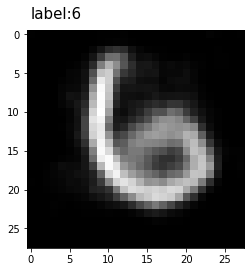

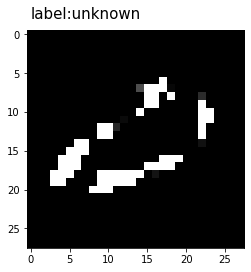

In [ ]:
img2 = torch.squeeze(outputs[0], 0).cpu().detach()
img1 = torch.squeeze(outputs[1], 0).cpu().detach()
img0 = torch.squeeze(outputs[2], 0).cpu().detach()
img6 = torch.squeeze(outputs[3], 0).cpu().detach()
img_unknown = torch.squeeze(outputs[4], 0).cpu().detach()
my_imshow(img2, '2')
my_imshow(img1, '1')
my_imshow(img0, '0')
my_imshow(img6, '6')
my_imshow(img_unknown, 'unknown')